# Data

In [3]:
from utils import *
config = load_config("config.yaml")

# read data source
df = pd.read_csv(config['data_path'])
cols = ['mean_x', 'mean_y', 'sigma_x', 'sigma_y', 'emittance_x', 'emittance_y', 'transmission']
data = pick_from_list_str(df, cols, index=-1)
# convert all string to float
data = convert_strings_to_float(data)
# to log scale
data = log_scale_df(data, cols=['emittance_x', 'emittance_y', 'transmission'])
# remove outliers (thresholding percentile)
cols = ['mean_x', 'mean_y', 'sigma_x', 'emittance_y', 'transmission']
data = add_valid_flag(data, cols, 0.01)
data = data[data['valid'] == 1].drop(columns=['valid']).reset_index(drop=True)
# normalized range
data = normalize_min_max(data)
data

,mean_x,mean_y,sigma_x,sigma_y,emittance_x,emittance_y,transmission,klne.zqmd.0208,klne.zqmf.0209,klne.zqmd.0214,klne.zqmf.0215
0,0.181227,0.459737,0.885248,0.080469,0.997911,0.544599,0.996907,0.0,0.0,0.0,0.4
1,0.698588,0.451018,0.414488,0.110824,0.852818,0.582239,1.000000,0.0,0.0,0.0,0.5
2,0.935848,0.517725,0.063270,0.139607,0.653094,0.609135,1.000000,0.0,0.0,0.0,0.6
3,0.938285,0.457610,0.525287,0.176318,0.687499,0.646394,1.000000,0.0,0.0,0.0,0.7
4,0.825219,0.631899,0.911655,0.213173,0.726836,0.681379,0.997595,0.0,0.0,0.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...
13503,0.272638,0.607202,0.142604,0.962824,0.435044,0.983623,0.112977,1.0,1.0,0.8,0.0
13504,0.331496,0.516794,0.133238,0.936539,0.435655,0.983268,0.327346,1.0,1.0,0.8,0.1
13505,0.379559,0.554197,0.128213,0.901167,0.456810,0.999556,0.585834,1.0,1.0,0.8,0.2
13506,0.292516,0.800908,0.138046,0.950224,0.475223,0.979064,0.023184,1.0,1.0,0.9,0.0


In [6]:
config

{'data_path': 'data/batch_results.csv',
 'input_cols': ['klne.zqmd.0208',
  'klne.zqmf.0209',
  'klne.zqmd.0214',
  'klne.zqmf.0215'],
 'target_cols': ['mean_x',
  'mean_y',
  'sigma_x',
  'sigma_y',
  'emittance_x',
  'emittance_y',
  'transmission'],
 'test_size': 0.1,
 'val_size': 0.1,
 'batch_size': 4,
 'learning_rate': 1e-05,
 'epochs': 60,
 'seed': 42,
 'patience': 5,
 'model_path': 'model/best_model.keras',
 'save_to': 'results/'}

# Training

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
config = load_config("config.yaml")

# ——— Model ———
def build_model(config):
    inp = tf.keras.Input(shape=(len(config['input_cols']),))
    
    # 1st block
    x = tf.keras.layers.Dense(128, use_bias=False)(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # 2nd block
    x = tf.keras.layers.Dense(128, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # 3rd block
    x = tf.keras.layers.Dense(64, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Dense(32, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # linear output for full-range regression
    out = tf.keras.layers.Dense(len(config['target_cols']))(x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.Huber(),
        # loss='mse',
        metrics=['mae']
    )
    return model

model = build_model(config)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 128)               512       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16384     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                             

Epoch 1/60


2025-07-16 13:57:32.677120: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


2702/2702 [==============================] - 56s 20ms/step - loss: 0.4303 - mae: 0.8038 - val_loss: 0.4462 - val_mae: 0.8090
Epoch 2/60
2702/2702 [==============================] - 51s 19ms/step - loss: 0.2293 - mae: 0.5508 - val_loss: 0.2558 - val_mae: 0.5742
Epoch 3/60
2702/2702 [==============================] - 53s 19ms/step - loss: 0.1301 - mae: 0.4049 - val_loss: 0.1844 - val_mae: 0.4742
Epoch 4/60
2702/2702 [==============================] - 53s 20ms/step - loss: 0.0893 - mae: 0.3335 - val_loss: 0.1543 - val_mae: 0.4259
Epoch 5/60
2702/2702 [==============================] - 50s 18ms/step - loss: 0.0715 - mae: 0.2975 - val_loss: 0.1316 - val_mae: 0.3888
Epoch 6/60
2702/2702 [==============================] - 49s 18ms/step - loss: 0.0609 - mae: 0.2736 - val_loss: 0.1134 - val_mae: 0.3584
Epoch 7/60
2702/2702 [==============================] - 50s 19ms/step - loss: 0.0533 - mae: 0.2555 - val_loss: 0.0980 - val_mae: 0.3318
Epoch 8/60
2702/2702 [==============================] - 52s

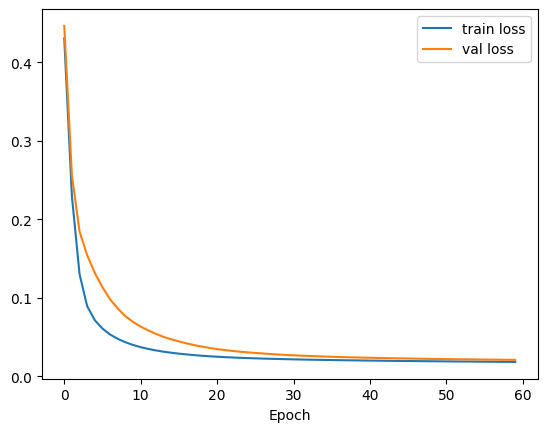

338/338 [==============================] - 2s 4ms/step


In [5]:
# ——— Data prep ———
X = data[config['input_cols']].to_numpy(dtype='float32')
y = data[config['target_cols']].to_numpy(dtype='float32')

n = X.shape[0]
idx = tf.random.shuffle(tf.range(n), seed=config['seed'])
n_test = int(config['test_size'] * n)
n_val  = int(config['val_size']  * n)

test_idx  = idx[:n_test]
val_idx   = idx[n_test:n_test+n_val]
train_idx = idx[n_test+n_val:]

def make_ds(indices):
    return (tf.data.Dataset
              .from_tensor_slices((tf.gather(X, indices),
                                   tf.gather(y, indices)))
              .batch(config['batch_size'])
              .prefetch(tf.data.AUTOTUNE))

train_ds, val_ds, test_ds = map(make_ds, (train_idx, val_idx, test_idx))


# ——— Callbacks ———
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config['patience'],
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=config['model_path'],
        monitor='val_loss',
        save_best_only=True
    )
]

# ——— Train ———
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config['epochs'],
    callbacks=callbacks,
    verbose=1
)
model.save(config['model_path'])
plot_history(history)

# ——— Eval ———
X_test = np.vstack([x for x, _ in test_ds])
y_test = np.vstack([y for _, y in test_ds])

# model predictions
y_pred = model.predict(test_ds)

# build and save dataframe
df_out = pd.DataFrame(
    np.hstack([X_test, y_test, y_pred]),
    columns=(
        config['input_cols']
      + [f"true_{c}" for c in config['target_cols']]
      + [f"pred_{c}" for c in config['target_cols']]
    )
)
df_out.to_csv(config['save_to'] + "test_results.csv", index=False)

# Evaluation

In [ ]:
from utils import *
config = load_config("config.yaml")

result = pd.read_csv(config['save_to']+"test_results.csv")
result = clip_df(result)
process_df(result, inputs=config['input_cols'], outputs=config['target_cols'], save_to=config['save_to'])

# Exploratory data analysis

In [ ]:
from utils import *

config = load_config("config.yaml")
cols = ['mean_x', 'mean_y', 'sigma_x', 'sigma_y', 'emittance_x', 'emittance_y', 'transmission']


temp = []
for i in range(8):
    df = pd.read_csv(config['data_path'])
    data = pick_from_list_str(df, cols, index=i)
    data = convert_strings_to_float(data)
    temp.append(data)
min_d, max_d = compute_bounds(temp)

temp = []
for i in range(8):
    df = pd.read_csv(config['data_path'])
    data = pick_from_list_str(df, cols, index=i)
    data = convert_strings_to_float(data)
    temp.append(plot_distributions(data, bins=200, min_bounds=min_d, max_bounds=max_d, title=f'segment_{i+1}'))

figures_to_gif(temp, config['save_to'])